In [50]:
import numpy as np
import duckdb
import pandas as pd
import seaborn as sns
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import preprocessing

In [51]:
data = pd.read_csv('BDC_2024_Womens_Data.csv')

# Focus Question: How does power plays influence the success of goals?
To prepare for this bigger question, we modeled each variable to the success of a goal. With this we look to reduce the amount of variables and eliminate less significant covariates and complexity of our final model. 

### In this section, we are modeling whether or not a goal was successful to the shot type.
### Summary of finding, only the shot types: snapshot and wrist shot are significant

In [52]:
query = """
        SELECT Event, "Detail 1" AS "Shot Type", 
        FROM data
        WHERE Event = 'Goal' OR Event = 'Shot'
        """
shots_df = duckdb.sql(query).df()
shots_df

shot_dummies = pd.get_dummies(shots_df["Shot Type"], drop_first = True)
shot_df = pd.concat([shots_df, shot_dummies], axis = 1)

# Conversion of the booleans into integer to use as binary variable
shot_df["Deflection"].replace({False: 0, True: 1}, inplace=True)
shot_df["Fan"].replace({False: 0, True: 1}, inplace=True)
shot_df["Poke"].replace({False: 0, True: 1}, inplace=True)
shot_df["Slapshot"].replace({False: 0, True: 1}, inplace=True)
shot_df["Snapshot"].replace({False: 0, True: 1}, inplace=True)
shot_df["Wrap Around"].replace({False: 0, True: 1}, inplace=True)
shot_df["Wristshot"].replace({False: 0, True: 1}, inplace=True)
shot_df["Event"].replace({"Shot": 0, "Goal": 1}, inplace=True)

shot_x = shot_df[shot_df.columns.difference(['Event', 'Shot Type'])]
shot_x = sm.add_constant(shot_x)
goal_y = shot_df["Event"]

lm_goal = sm.OLS(endog = goal_y, exog = shot_x).fit()

print (lm_goal.pvalues)
print (lm_goal.params)
# We can see here that the shot type is not significant. This is likely due to
# the tendency of players to use advantagous shot types such as deflection, slapshot,
# and snapshot when attempting a goal

const          1.000000
Deflection     0.734023
Fan            1.000000
Poke           1.000000
Slapshot       0.865090
Snapshot       0.823449
Wrap Around    1.000000
Wristshot      0.820701
dtype: float64
const          3.543987e-14
Deflection     7.407407e-02
Fan           -3.545696e-14
Poke          -3.530102e-14
Slapshot       3.703704e-02
Snapshot       4.790419e-02
Wrap Around   -3.549969e-14
Wristshot      4.864865e-02
dtype: float64


### In this section, we are modeling whether or not a goal was successful to the details which are one timer and traffic.
### Summary of finding, these details attach to a goal entry are statistically significant.

In [53]:
detail_data = duckdb.sql("""
                            SELECT Event AS "Goal",
                            "Detail 3" AS "Traffic",
                            "Detail 4" AS "One-timer"
                            FROM data
                            WHERE (Event = 'Goal' OR Event = 'Shot')
                            """).df()

detail_data["Traffic"].replace({"f": 0, "t": 1}, inplace=True)
detail_data["One-timer"].replace({"f": 0, "t": 1}, inplace=True)
detail_data["Goal"].replace({"Shot": 0, "Goal": 1}, inplace=True)


X = detail_data[detail_data.columns.difference(["Goal"])]
y = detail_data["Goal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the logistic regression model
model = sm.Logit(endog = y_train, exog = X_train).fit()
print (model.summary())

# Testing how well the model does on test
# Looking at the unqiue values of y_prob, the predicted log-odds, we determined
# that the threshold should be 0.5 to not have all 0s. 
y_prob = model.predict(X_test)
y_pred = np.zeros(len(y_prob))
for i in range (len(y_pred)):
    if y_prob.iloc[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# We have a low precision and high recall, which shows that our model returns a lot
# false positives, which is expected given the low threshold.
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Optimization terminated successfully.
         Current function value: 0.345294
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   Goal   No. Observations:                  296
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                 -0.7222
Time:                        21:40:34   Log-Likelihood:                -102.21
converged:                       True   LL-Null:                       -59.348
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
One-timer     -1.6932      0.486     -3.481      0.000      -2.647      -0.740
Traffic       -4.8497      1.

From the summary of the logistic regression, we have that both of these variables are significant. 
If there is traffic, assuming all else equals, change of log-odds is approximately -4.8497. In other words, we can conclude that if there is traffic, the model predicts  approximately 0.78% increase in the odds of a goal being made. 
If the shot is a one-timer, assuming all else equals, the player shooting shot the goal with a slapshot right after recieving a pass, the change of log odds is approximately -1.6932 which means the model predicts an approximate 18.39% increase in the odds of a goal being made.

### In this section, we are modeling whether or not a goal was successful to the euclidean distance and angle from the center of the goal to the location that the goal attempt was made.
### Summary of finding: The euclidean distance to the center of the goal is statistically significant.

In [54]:
# The function will use arctangent to calculate the angle using two ordered pairs.
# The output will be in terms of radians and will be the degree of the reference angle.
# Precondition, x1 must be the same type as y1. x2 must be the same type as y2.
# Parameters: 
    # x - a vector list or single value of the x-coordinate of point 1
    # y - a vector list or single value of the y-coordinate of point 1
    # x2 - a vector list or single value of the x-coordinate of point 2
    # y2 - a vector list or single value of the y-coordinate of point 2
    # vector - an array or single value where the calculated values will be saved.
def angle (x, y, x2, y2, vector):
    assert(type(x) == type(y))
    assert(type(x2) == type(y2))
    #if (type(x2) == int and type(y2) == int):
    y_dist = y - y2
    x_dist = x - x2
    for i in range(len(x_dist)):
        if (y_dist[i] == 0):
            vector[i] = 0
        elif (x_dist[i] == 0):
            vector[i] = math.pi / 2
        else:
            vector[i] = abs(math.atan(y_dist[i]/x_dist[i]))



# This function uses the formula of Euclidean Distance between 2 points to calculate
# distance given points.
# Precondition, x1 must be the same type as y1. x2 must be the same type as y2.
    # x1 - a vector list or single value of the x-coordinate of point 1
    # y2 - a vector list or single value of the y-coordinate of point 1
    # x2 - a vector list or single value of the x-coordinate of point 2
    # y2 - a vector list or single value of the y-coordinate of point 2
    # vector - an array or single value where the calculated values will be saved.
def euclidean_dist (x1, y1, x2, y2, vector):
    assert(type(x1) == type(y1))
    assert(type(x2) == type(y2))
    x_diff = x1 - x2
    y_diff = y1 - y2
    for i in range (len(x1)):
        vector[i] = np.sqrt((x_diff[i])**2 + (y_diff[i])**2)

In [55]:
shot_distance = duckdb.sql("""
                            SELECT Player, Event,
                           "X Coordinate" AS X_Coordinate,
                           "Y Coordinate" AS Y_Coordinate
                           FROM data
                           WHERE (Event = 'Goal' OR Event = 'Shot')
                            """).df()

angle_vector = np.zeros(len(shot_distance))

angle(shot_distance["X_Coordinate"], shot_distance["Y_Coordinate"],
                               189.0, 42.5, angle_vector)

#print(angle_vector)
#print (shot_distance["Y Coordinate"][2])
#Currently negative angles are allowed, do we want that to be true? or all positives?
shot_distance["Shot Angle"] = angle_vector

dist_vector = np.zeros(len(shot_distance))
euclidean_dist(shot_distance["X_Coordinate"], shot_distance["Y_Coordinate"],
                               189.0, 42.5, dist_vector)

shot_distance["Shot Distance"] = dist_vector

shot_distance["Event"].replace({"Shot":0,"Goal":1}, inplace = True)
#shot_distance["Goal"] = np.where(shot_distance["Event"] == "Goal", 1, 0)
shot_distance

X = shot_distance[["Shot Distance", "Shot Angle"]]
y = shot_distance["Event"]

# Since the shot distance and shot angle are at very different scales, this would
# impact the coefficients. 
# Applies z = (x - u) / s to the values
def Normalizer(df_cols):
    scaler = preprocessing.StandardScaler().fit(df_cols)
    return(scaler.transform(df_cols))

X = Normalizer(X.values)
X = sm.add_constant(X)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y,
                            test_size=0.3, random_state=2940)

# Fitting the logistic regression model
model2 = sm.Logit(endog = y_train2, exog = X_train2).fit()
print (model2.summary())

# Testing how well the model does on test
# Looking at the unqiue values of y_prob, the predicted log-odds, we determined
# that the threshold should be 0.5 to not have all 0s. 
y_prob2 = model2.predict(X_test2)
y_pred2 = np.zeros(len(y_prob2))
for i in range (len(y_pred2)):
    if y_prob2[i] >= 0.1:
        y_pred2[i] = 1
    else:
        y_pred2[i] = 0

# We have a low precision and low recall, which shows that our model does not succeed in 
# correctly identifying the true positives, which can be attributed to the lack of 
# goals in this dataset.
print("Precision:", precision_score(y_test2, y_pred2))
print("Recall:", recall_score(y_test2, y_pred2))
print("F1:", f1_score(y_test2, y_pred2))


Optimization terminated successfully.
         Current function value: 0.160157
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Event   No. Observations:                  296
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1112
Time:                        21:40:34   Log-Likelihood:                -47.406
converged:                       True   LL-Null:                       -53.341
Covariance Type:            nonrobust   LLR p-value:                  0.002648
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6016      0.423     -8.508      0.000      -4.431      -2.772
x1            -1.0950      0.

We can see that statistically speaking, distance has a relationship with whether or not a goal is made while angle does not. 
In particular, our model predicts that the log odds of a goal changes by -1.0950 as distance increases. Another possible interpretation is that the probability of a successful goal increases by approximately 33.45% as distance increases by one unit.

## Creation of Final Model

From the analysis and statistical model, we have that of all the details provided for a goal or shot entry, the euclidean distance to the goal, traffic, and one-timer are the three significant covariates. Therefore, we will look to use these three covariates in our final model. 

In [56]:
power_play = duckdb.sql(
                        """
                        SELECT "X Coordinate" AS X_Coordinate,
                        "Y Coordinate" AS Y_Coordinate,
                        "Home Team", "Away Team",
                        "Home Team Skaters", "Away Team Skaters",
                        Player, Team, Event AS "Goal", 
                        "Detail 3" AS "Traffic",
                        "Detail 4" AS "One-Timer"
                        FROM data
                        WHERE Event = 'Goal' OR Event = 'Shot'
                        """).df()
power_play["Traffic"].replace({"f":0,"t":1}, inplace = True)
power_play["One-Timer"].replace({"f":0,"t":1}, inplace = True)
power_play["Goal"].replace({"Shot":0,"Goal":1}, inplace = True)
power_play

,X_Coordinate,Y_Coordinate,Home Team,Away Team,Home Team Skaters,Away Team Skaters,Player,Team,Goal,Traffic,One-Timer
0,185,37,Women - United States,Women - Canada,5,5,Hilary Knight,Women - United States,1,0,0
1,179,51,Women - United States,Women - Canada,5,5,Brianne Jenner,Women - Canada,1,0,0
2,175,53,Women - United States,Women - Canada,5,5,Taylor Heise,Women - United States,1,0,1
3,175,53,Women - United States,Women - Canada,5,5,Alex Carpenter,Women - United States,1,0,0
4,129,5,Women - United States,Women - Canada,5,5,Megan Keller,Women - United States,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
418,154,41,Women - Canada,Women - United States,3,3,Taylor Heise,Women - United States,0,1,0
419,170,55,Women - Canada,Women - United States,3,3,Taylor Heise,Women - United States,0,0,0
420,140,36,Women - Canada,Women - United States,3,3,Ella Shelton,Women - Canada,0,1,0
421,163,45,Women - Canada,Women - United States,3,3,Sarah Nurse,Women - Canada,0,0,0


In [57]:
# This function codes every goal or shot entry to a binary value representing whether
# or not the team of the player who attempted the goal is is currently in a powerplay or not.
def special_coder(home, hplayer, aplayer, pteam):
    results = np.zeros(len(home))
    for i in range (len(home)):
        if (pteam[i] == home[i]):
            # if player is a player of the home team
            if (hplayer[i] > aplayer[i]):
                results[i] = 1
            else:
                results[i] = 0
        else:
            if (aplayer[i] > hplayer[i]):
                results[i] = 1
            else:
                results[i] = 0  
    return (results)              

In [58]:
power_play["Power Play"] = special_coder(power_play["Home Team"],
                                         power_play["Home Team Skaters"],
                                         power_play["Away Team Skaters"],
                                         power_play["Team"])


In [59]:
dist_vector = np.zeros(len(shot_distance))
euclidean_dist(power_play["X_Coordinate"], power_play["Y_Coordinate"],
                               189.0, 42.5, dist_vector)

power_play["Shot Distance"] = dist_vector

power_play

,X_Coordinate,Y_Coordinate,Home Team,Away Team,Home Team Skaters,Away Team Skaters,Player,Team,Goal,Traffic,One-Timer,Power Play,Shot Distance
0,185,37,Women - United States,Women - Canada,5,5,Hilary Knight,Women - United States,1,0,0,0.0,6.800735
1,179,51,Women - United States,Women - Canada,5,5,Brianne Jenner,Women - Canada,1,0,0,0.0,13.124405
2,175,53,Women - United States,Women - Canada,5,5,Taylor Heise,Women - United States,1,0,1,0.0,17.500000
3,175,53,Women - United States,Women - Canada,5,5,Alex Carpenter,Women - United States,1,0,0,0.0,17.500000
4,129,5,Women - United States,Women - Canada,5,5,Megan Keller,Women - United States,0,0,0,0.0,70.754858
...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,154,41,Women - Canada,Women - United States,3,3,Taylor Heise,Women - United States,0,1,0,0.0,35.032128
419,170,55,Women - Canada,Women - United States,3,3,Taylor Heise,Women - United States,0,0,0,0.0,22.743131
420,140,36,Women - Canada,Women - United States,3,3,Ella Shelton,Women - Canada,0,1,0,0.0,49.429242
421,163,45,Women - Canada,Women - United States,3,3,Sarah Nurse,Women - Canada,0,0,0,0.0,26.119916


In [60]:
X_power = power_play.loc[:,["Traffic", "One-Timer", "Shot Distance", "Power Play"]]
X_power

X_power = sm.add_constant(X_power)

y_power = power_play["Goal"]

In [61]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_power, y_power,
                            test_size=0.3, random_state=2940)

# Fitting the logistic regression model
model3 = sm.Logit(endog = y_train3, exog = X_train3).fit()
print (model3.summary())

# Testing how well the model does on test
# Looking at the unqiue values of y_prob, the predicted log-odds, we determined
# that the threshold should be 0.5 to not have all 0s. 
y_prob3 = model3.predict(X_test3)
y_pred3 = np.zeros(len(y_prob3))
for i in range (len(y_pred3)):
    if y_prob3.iloc[i] >= 0.1:
        y_pred3[i] = 1
    else:
        y_pred3[i] = 0

# We have a low precision and low recall, which shows that our model does not succeed in 
# correctly identifying the true positives, which can be attributed to the lack of 
# goals in this dataset.
print("Precision:", precision_score(y_test3, y_pred3))
print("Recall:", recall_score(y_test3, y_pred3))
print("F1:", f1_score(y_test3, y_pred3))

Optimization terminated successfully.
         Current function value: 0.158612
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   Goal   No. Observations:                  296
Model:                          Logit   Df Residuals:                      291
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1198
Time:                        21:40:34   Log-Likelihood:                -46.949
converged:                       True   LL-Null:                       -53.341
Covariance Type:            nonrobust   LLR p-value:                   0.01239
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.9155      0.599     -3.200      0.001      -3.089      -0.742
Traffic          -0.

In [62]:
def bestModel(inputData, ycol = y_power):
    inputData = sm.add_constant(inputData)
    aiclist=[]
    plist = []
    coeflist = []
    numCol = inputData.shape[1]
    colName = inputData.columns.values.tolist()
    index = 0
    
    for i in range (0,numCol-1):
        var_model = sm.Logit(endog = ycol, exog = inputData).fit(disp = False)
        aiclist.append(var_model.aic)
        plist.append(var_model.pvalues)
        coeflist.append(var_model.params)
        ## As i increases, removes the variables one by one
        inputData = inputData.iloc[:,:-1]

        
    ## We need to add one to the index because the index returns the position of
    # the most recently dropped variable and the best model based on the 
    best_model_index = aiclist.index(np.min(aiclist))
    result_df = pd.DataFrame({"coef":coeflist[best_model_index],"p":plist[best_model_index]})
    print ("The coefficients and p-values for the smallest AIC model with the pivot column", 
           colName[1], "is \n", result_df, "\n")
    return np.min(aiclist)

In [63]:
min_aic_list = []
input_vars = ["Traffic", "One-Timer", "Shot Distance", "Power Play"]
for i in range (len(input_vars)):
    temp_input_vars = input_vars[i:] + input_vars[:i]
    min_aic_list.append(bestModel(power_play[temp_input_vars], y_power))
print ("The list of smallest aic for all possible models is: ", min_aic_list)
print ("The smallest AIC is", np.min(min_aic_list),"\n")

The coefficients and p-values for the smallest AIC model with the pivot column Traffic is 
                    coef         p
const         -1.424400  0.001491
Traffic       -1.324837  0.107275
One-Timer      0.239554  0.662833
Shot Distance -0.053489  0.013626 

The coefficients and p-values for the smallest AIC model with the pivot column One-Timer is 
                    coef         p
const         -1.316374  0.003005
One-Timer      0.236133  0.665705
Shot Distance -0.072777  0.000264 

The coefficients and p-values for the smallest AIC model with the pivot column Shot Distance is 
                    coef         p
const         -1.256630  0.002602
Shot Distance -0.073108  0.000229 

The coefficients and p-values for the smallest AIC model with the pivot column Power Play is 
                    coef         p
const         -1.391720  0.002452
Power Play    -0.216212  0.743116
Traffic       -1.294325  0.118372
One-Timer      0.248278  0.652019
Shot Distance -0.053630  0.013701 

T

We can see that the best models for each pivot column includes shot distance and shot distance is always statistically significant in all the models with a p-value of lower than 0.05. In fact, of all possible models, the model with the smallest AIC value is the simple regression model with just shot distance. 

However, we hypothesize that when a team is in power play, they will be able to get closer to the center of the goal. Therefore, we created a plot displaying whether or not the team is in power play, the distance from the goal at the time of the attempt, and whether or not the goal attempt was successful. 

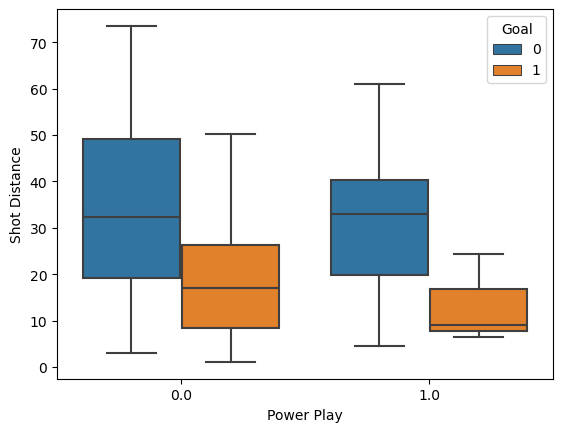

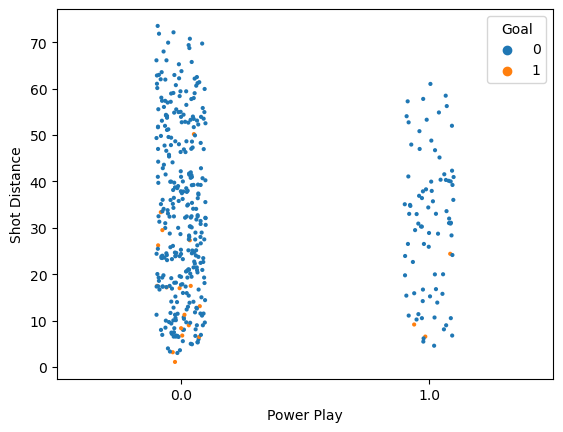

In [64]:
sns.boxplot(x = power_play["Power Play"], y = power_play["Shot Distance"], hue = power_play["Goal"])
plt.show()

sns.stripplot(x = power_play["Power Play"], y = power_play["Shot Distance"], hue = power_play["Goal"], s = 3) 
plt.show()

In [65]:
df = pd.DataFrame({"Power Play": power_play["Power Play"], 
                   "Distance": power_play["Shot Distance"],
                   "goal": power_play["Goal"],
                  "X": power_play["X_Coordinate"],
                  "Y": power_play["Y_Coordinate"]})

df.corr()

,Power Play,Distance,goal,X,Y
Power Play,1.000000,-0.045766,-0.027129,0.042267,-0.002738
Distance,-0.045766,1.000000,-0.198025,-0.934000,0.060462
goal,-0.027129,-0.198025,1.000000,0.148702,-0.000316
X,0.042267,-0.934000,0.148702,1.000000,-0.064991
Y,-0.002738,0.060462,-0.000316,-0.064991,1.000000


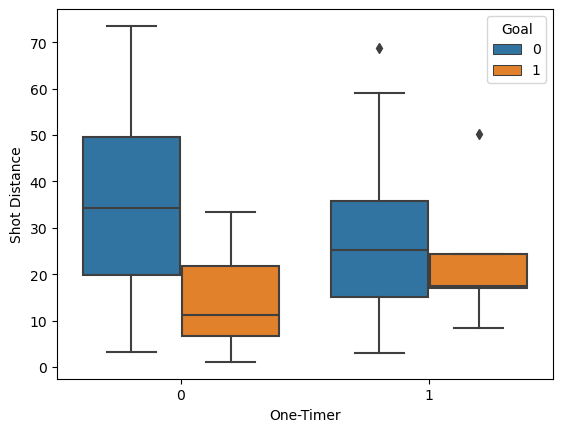

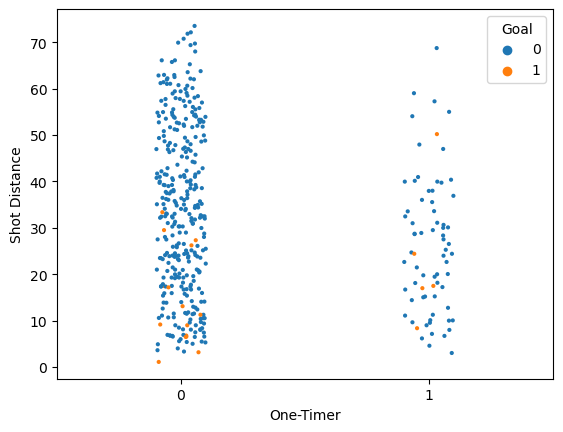

In [66]:
sns.boxplot(x = power_play["One-Timer"], y = power_play["Shot Distance"], hue = power_play["Goal"])
plt.show()

sns.stripplot(x = power_play["One-Timer"], y = power_play["Shot Distance"], hue = power_play["Goal"], s = 3) 
plt.show()

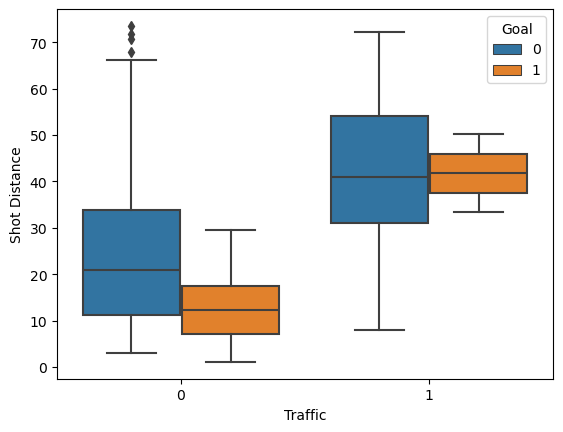

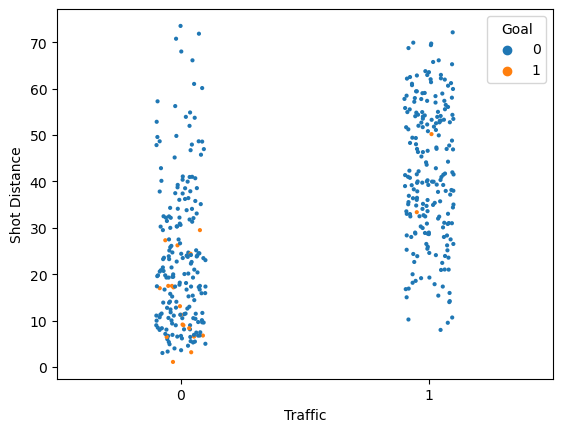

In [67]:
sns.boxplot(x = power_play["Traffic"], y = power_play["Shot Distance"], hue = power_play["Goal"])
plt.show()

sns.stripplot(x = power_play["Traffic"], y = power_play["Shot Distance"], hue = power_play["Goal"], s = 3) 
plt.show()

In [68]:
one_traffic_df = pd.DataFrame({"Traffic": power_play["Traffic"], 
                  "One-Timer": power_play["One-Timer"],
                  "Distance": power_play["Shot Distance"],
                  "Power Play": power_play["Power Play"]})

one_traffic_df.corr()

,Traffic,One-Timer,Distance,Power Play
Traffic,1.000000,-0.067999,0.517312,0.079360
One-Timer,-0.067999,1.000000,-0.160792,0.152985
Distance,0.517312,-0.160792,1.000000,-0.045766
Power Play,0.079360,0.152985,-0.045766,1.000000


In [71]:
power = power_play["Power Play"]
goal = power_play["Goal"]
total_power_plays = power.sum()
total_power_play_goals = goal.sum()
success_rate = (total_power_play_goals / total_power_plays) * 100
success_rate

23.809523809523807